In [120]:
#pip install openmeteo-requests requests-cache retry-requests

### Fetch Current and Daily Weather Forecast from Open-Meteo API

In [58]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import os

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# List of coordinates (latitude and longitude) for each MA county
ma_counties_coordinates = [
    {"county_name": "Barnstable", "latitude": 41.7003, "longitude": -70.3002},
    {"county_name": "Berkshire", "latitude": 42.3118, "longitude": -73.1822},
    {"county_name": "Bristol", "latitude": 41.7938, "longitude": -71.1350},
    {"county_name": "Dukes", "latitude": 41.4033, "longitude": -70.6693},
    {"county_name": "Essex", "latitude": 42.6334, "longitude": -70.7829},
    {"county_name": "Franklin", "latitude": 42.5795, "longitude": -72.6151},
    {"county_name": "Hampden", "latitude": 42.1175, "longitude": -72.6009},
    {"county_name": "Hampshire", "latitude": 42.3389, "longitude": -72.6417},
    {"county_name": "Middlesex", "latitude": 42.4672, "longitude": -71.2874},
    {"county_name": "Nantucket", "latitude": 41.2835, "longitude": -70.0995},
    {"county_name": "Norfolk", "latitude": 42.1621, "longitude": -71.1912},
    {"county_name": "Plymouth", "latitude": 41.9880, "longitude": -70.7528},
    {"county_name": "Suffolk", "latitude": 42.3601, "longitude": -71.0589},
    {"county_name": "Worcester", "latitude": 42.4002, "longitude": -71.9065}
]

# Dictionary to store weather data by county
county_weather_data = {}

# Function to fetch and process weather data for a given set of coordinates
def fetch_weather_data(county_name, latitude, longitude):
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
	        "current": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "weather_code", "wind_speed_10m", "wind_direction_10m", "wind_gusts_10m"],
	    "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "sunrise", "sunset", "uv_index_max", "precipitation_probability_max", "wind_speed_10m_max", "wind_gusts_10m_max"],
        "timezone": "America/New_York",
        "temperature_unit": "fahrenheit",
        "wind_speed_unit": "mph",
        "precipitation_unit": "inch",
        "forecast_days": 7
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process the response for the given coordinates
    response = responses[0]

    # Process current data
    current = response.Current()
    current_temperature_2m = current.Variables(0).Value()
    current_relative_humidity_2m = current.Variables(1).Value()
    current_apparent_temperature = current.Variables(2).Value()
    current_precipitation = current.Variables(3).Value()
    current_weather_code = current.Variables(4).Value()
    current_wind_speed_10m = current.Variables(5).Value()
    current_wind_direction_10m = current.Variables(6).Value()
    current_wind_gusts_10m = current.Variables(7).Value()

    # Prepare current weather data for DataFrame
    current_data = {
        "time": [pd.to_datetime(current.Time(), unit="s", utc=True)],
        "temperature_2m": [current_temperature_2m],
        "relative_humidity_2m": [current_relative_humidity_2m],
        "apparent_temperature": [current_apparent_temperature],
        "precipitation": [current_precipitation],
        "weather_code": [current_weather_code],
        "wind_speed_10m": [current_wind_speed_10m],
        "wind_direction_10m": [current_wind_direction_10m],
        "wind_gusts_10m": [current_wind_gusts_10m],
    }

    # Create a DataFrame from the current weather data
    current_df = pd.DataFrame(data=current_data)

    # Process daily data
    daily = response.Daily()
    daily_data = {
        "date": pd.date_range(
            start=pd.to_datetime(daily.Time(), unit="s", utc=True),
            end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=daily.Interval()),
            inclusive="left"
        ),
        "county": county_name,
        "latitude": latitude,
        "longitude": longitude,
        "weather_code": daily.Variables(0).ValuesAsNumpy(),
        "temperature_2m_max": daily.Variables(1).ValuesAsNumpy(),
        "temperature_2m_min": daily.Variables(2).ValuesAsNumpy(),
        "sunrise": daily.Variables(3).ValuesAsNumpy(),
        "sunset": daily.Variables(4).ValuesAsNumpy(),
        "uv_index_max": daily.Variables(5).ValuesAsNumpy(),
        "precipitation_probability_max": daily.Variables(6).ValuesAsNumpy(),
        "wind_speed_10m_max": daily.Variables(7).ValuesAsNumpy(),
        "wind_gusts_10m_max": daily.Variables(8).ValuesAsNumpy()
    }
    daily_df = pd.DataFrame(daily_data)

    # Store DataFrames in the dictionary by county
    county_weather_data[county_name] = {
        "current": current_df,
        "daily": daily_df
    }
    print(f"Processed weather data for {county_name}")

# Loop through each set of coordinates and fetch weather data
for county in ma_counties_coordinates:
    fetch_weather_data(county["county_name"], county["latitude"], county["longitude"])

Processed weather data for Barnstable
Processed weather data for Berkshire
Processed weather data for Bristol
Processed weather data for Dukes
Processed weather data for Essex
Processed weather data for Franklin
Processed weather data for Hampden
Processed weather data for Hampshire
Processed weather data for Middlesex
Processed weather data for Nantucket
Processed weather data for Norfolk
Processed weather data for Plymouth
Processed weather data for Suffolk
Processed weather data for Worcester


### Chloropeth Map for Current Weather Features

In [ ]:
import geopandas as gpd

# Load the shapefile into a GeoDataFrame
shapefile_path = '../DS5110-Final-Project/dataset/raw_data/tl_2024_us_county/tl_2024_us_county.shp'
gdf = gpd.read_file(shapefile_path)

# Filter out Massachusetts counties
ma_counties = gdf[gdf['STATEFP'] == '25']
ma_counties["NAME"].unique()

<Axes: >

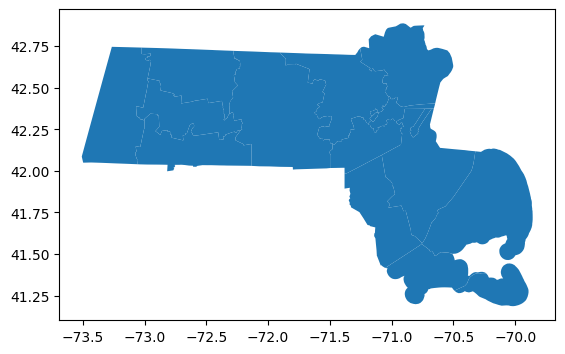

In [2]:
import matplotlib.pyplot as plt

# Plot the Massachusetts counties
ma_counties.plot()

In [3]:
# Convert GeoDataFrame to GeoJSON for Folium compatibility
ma_counties = ma_counties.to_crs("EPSG:4326") 
geojson_data = gdf.to_json()

In [117]:
import folium
import random

# Create a base Folium map centered around Massachusetts
m = folium.Map(location=[42.4072, -71.3824], zoom_start=7, tiles="cartodbpositron")

# Create a function to generate random colors for each county
def random_color():
    return f'#{random.randint(0, 255):02x}{random.randint(0, 255):02x}{random.randint(0, 255):02x}'

# Add counties as a GeoJSON layer with unique colors and tooltips
for _, row in ma_counties.iterrows():
    county_name = row['NAME']
    weather_info = county_weather_data[county_name]["current"]
    
    popup_text = (
    f"Temperature: {round(weather_info['temperature_2m'].values[0])} °F<br>"
    f"Humidity: {weather_info['relative_humidity_2m'].values[0]} %<br>"
    f"Precipitation: {weather_info['precipitation'].values[0]} in<br>"
    f"Wind Speed: {round(weather_info['wind_speed_10m'].values[0], 2)} mph<br>"
    f"Wind Direction: {round(weather_info['wind_direction_10m'].values[0], 2)} °<br>"
    f"Wind Gusts: {round(weather_info['wind_gusts_10m'].values[0], 2)} mph"
)

    
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature, color=random_color(): {
            'fillColor': color,
            'color': 'black',
            'weight': 0.5,
            'fillOpacity': 0.6,
        },
        tooltip=folium.Tooltip(county_name),
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Display the map
m

In [118]:
output_dir = 'visualizations'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'chloropeth_map.html')
m.save(output_file)


### Temperature Heatmap by Counties

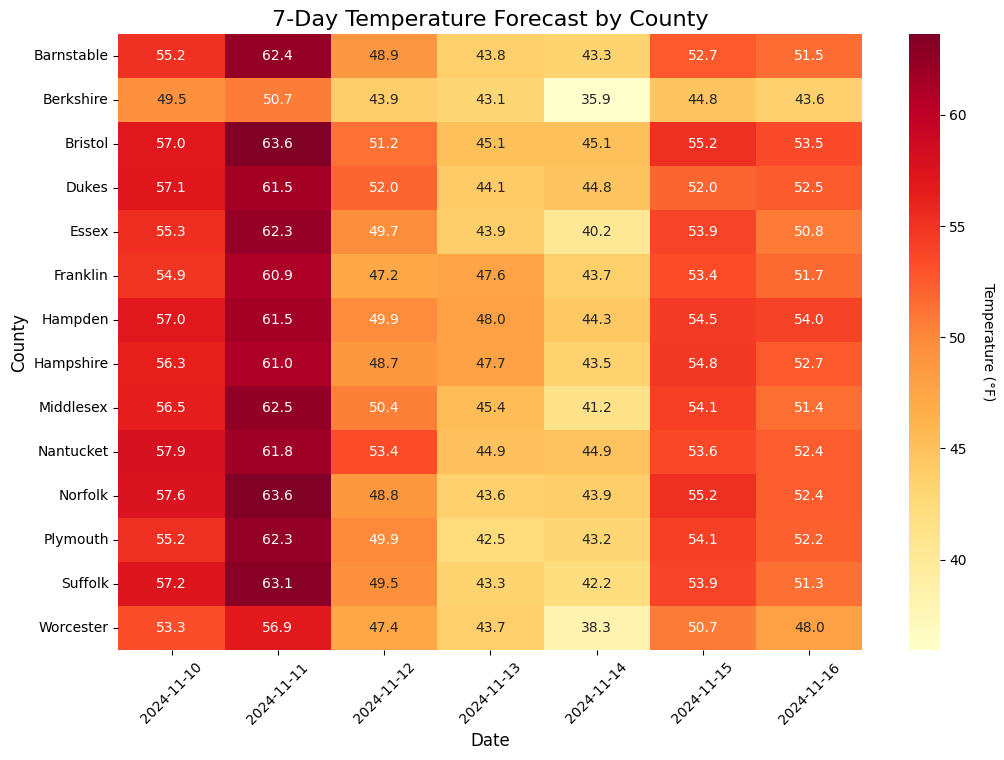

In [142]:
# Create a heatmap of temperature by county
temperature_data = pd.DataFrame()
for county, weather_data in county_weather_data.items():
    daily_data = weather_data["daily"]
    temperature_data[county] = daily_data["temperature_2m_max"]

# Convert the index values to actual dates
temperature_data.index = daily_data["date"].dt.date

# Plot the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(temperature_data.transpose(), cmap="YlOrRd", annot=True, fmt=".1f", cbar=True)

# Customizing the color bar to include "°F"
color_bar = heatmap.collections[0].colorbar
color_bar.set_label('Temperature (°F)', rotation=270, labelpad=20)

plt.title("7-Day Temperature Forecast by County", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("County", fontsize=12)
plt.xticks(rotation=45)
plt.show()
